# 飞桨论文复现赛 第七期 Unsupervised deep learning for super-resolution reconstruction of turbulence

**什么是惊喜队**

## 简介

本项目主要是用以复现[Unsupervised deep learning for super-resolution reconstruction of turbulence](https://arxiv.org/abs/2007.15324)文章。原文作者在github中[开放了部分的源代码](https://github.com/HyojinKim-github/SR-Turb-CycleGAN)，但源代码是tensorflow构建的，同时代码中有少许不合理的地方，修复后也无法实现原文中的精度。

本文使用了Paddle重现该文章的工作，附带了一部分[Johns Hopkins Turbulence Databases](http://turbulence.pha.jhu.edu/datasets.aspx)的数据用作该项目的可视化验证。本项目与原始的代码实现的差异主要有如下：

- 扩大了网络的规模；
- 引入了residual connection；
- 对湍流速度场的数据进行了缩放，并让模型最后输出可以tanh激活；
- 重现了原文没有实现的数据IO等训练管线


## 原文介绍

湍流数值模拟结果的超分辨率一直是近年来的研究热点，通过深度学习模型将低分辨率的结果细化成高分辨率的结果可以大幅度地节省传统数值模拟的计算耗时。但是之前的研究都是使用了监督学习的方式，使用成对的高低分辨率数据进行训练，在一些流体力学的应用场景里面（例如Large eddy simulation），这样的成对数据可能不好获得。所以本文作者提出了使用CycleGAN进行无监督的方式来训练湍流的超分模型。

本文提出的超分辨率模型是基于CycleGAN训练的，训练的时候可以输入*不成对的高低分辨率湍流数值模拟结果*，假设我们称低分辨率数据为LR，高分辨率为HR，则该框架同时训练以下四个模型；

- $G(LR) \rightarrow \widehat{HR}$：超分辨率模型
- $F(HR) \rightarrow \widehat{LR}$：降采样模型
- $DX(LR) \rightarrow (0,1)$：低分辨率数据的辨别器
- $DY(HR) \rightarrow (0,1)$：高分辨率数据的辨别器

在训练的时候，我们将会同时输入不成对的低分辨率数据X，高分辨率数据Y：

1. 计算$\widehat{Y} = G(X), \widehat{X} = F(Y)$，
2. 计算辨别器损失：Loss_DX = DX(X) - DX(F(Y))， Loss_DY = DY(Y) - DY(G(X))
3. 计算循环损失: Loss_cycle = (Y - G(F(Y)))^2 + (X - F(G(X))^2
4. 计算生成器的损失：Loss_G = Loss_cycle + DY(G(X))， Loss_F = Loss_cycle + DX(F(Y))
4. 完成梯度的backprop

## 项目架构简单说明

- main.ipynb：本notebook，展示了项目的基础结构和一些流程；
- models/generators.py, models/discriminators.py：生成和辨别模型的定义
- utils/
    - loss.py：定义了损失的计算方法
    - dataloader.py：定义了数据的IO管线
    - functions.py：一些常用的函数，包括2X和0.5X层的定义

## 运行方法

直接点击“运行全部”，将会加载已经训练好的权重进行超分辨率重建；

在“开始训练”章节将两行代码取消注释，将会训练一个全新的模型

## 数据集 JHTDB

我们附带了用来验证训练管线和结果的可视化，按照原文描述，该超分辨率模型尝试复现的是速度场，对应的数据库名称是[Forced isotropic turbulence](http://turbulence.pha.jhu.edu/Forced_isotropic_turbulence.aspx)。JHTDB提供的是$1024^3$格点里面的3维速度场数据(u,v,w)。每次训练时，我们会固定z = 0，在x-y平面中截取$128^2$的数据(128,128,3)，而低分辨率数据则通过在高分辨率数据中取2\*2的区块进行平均得出(32,32,3)。该项目已经挂载了相应的数据集，可以直接看到

In [ ]:
# 展示已经挂载的JHTDB cutout
!ls data/

### First things first

依赖项目安装：
- h5py 用以读取cutout
- tqdm 用以展示训练进度条

按照说明安装在自建的路径，以后直接挂载

In [ ]:
# 如果你是在aistudio 运行，可以使用下面的命令
!mkdir -p external-libraries
!pip install tqdm -t external-libraries --upgrade
!pip install h5py -t external-libraries --upgrade

!mkdir -p saved_models
!mkdir -p log

In [ ]:
# 如果你是本地运行，使用下面命令
# !pip install tqdm --upgrade
# !pip install h5py --upgrade

In [ ]:
import sys
sys.path.append('external-libraries')

## 代码主体

### 超参数设定

以下是超参数的设定

In [2]:
import paddle as pd
import paddle.nn as nn
from paddle.io import DataLoader
from models.discriminators import DiscriminatorX, DiscriminatorY
from models.generators import GeneratorG, GeneratorF
from utils.dataloader import TurbulenceDataset, get_energy
from utils.loss import wgp_slope_condition, identity_loss, cycle_consistency_loss


import os
from tqdm import tqdm
import numpy as np

# 学习率
LEARNING_RATE = 1e-4
# 训练轮次
EPOCHS = 50
# 梯度惩罚的损失乘数
LAMBDA_GRAD = 10
# 循环一致性的损失乘数
LAMBDA_CYCLE = 200
# 批次大小
BATCH_SIZE = 8

# 用来计算cross entropy的标靶
ALL_TRUE = pd.to_tensor([1] * BATCH_SIZE, dtype="float32")
ALL_FALSE = pd.to_tensor([0] * BATCH_SIZE, dtype="float32")

# 设定日志
from datetime import datetime
from visualdl import LogWriter
RUN = datetime.now().strftime("%Y-%m-%d-%H%M%S")
writer = LogWriter(logdir=f"./log/train_{RUN}")

c:\Users\kinet\anaconda3\envs\paddle\lib\site-packages\paddle\tensor\creation.py:125: DeprecationWarning: `np.object` is a deprecated alias for the builtin `object`. To silence this warning, use `object` by itself. Doing this will not modify any behavior and is safe. 
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if data.dtype == np.object:


### 生成器和鉴别器相关的函数

In [3]:


def generate_step(X: pd.Tensor, Y: pd.Tensor, genG: nn.Layer, genF: nn.Layer) -> tuple:
    """
    给定一对高低分辨率的湍流数据，使用generatorG和generatorF完成对应的生成步骤：
    genG(X) -> Y_predict: 生成器G将低分辨率的X转换为高分辨率的Y_predict
    genG(X_predict) -> Y_cycle: 生成器G将低分辨率的X_predict转换为高分辨率的Y_cycle

    genF(Y) -> X_predict: 生成器F将高分辨率的Y转换为低分辨率的X_predict
    genF(Y_predict) -> X_cycle: 生成器F将高分辨率的Y_predict转换为低分辨率的X_cycle

    最后组装成一个字典返回
    """
    Y_predict = genG(X)
    X_cycle = genF(Y_predict)

    X_predict = genF(Y)
    Y_cycle = genG(X_predict)

    return {
        "X_predict": X_predict,
        "Y_predict": Y_predict,
        "X_cycle": X_cycle,
        "Y_cycle": Y_cycle,
        "X_real": X,
        "Y_real": Y,
    }


def discriminate_step(gen_dict: dict, discX: nn.Layer, discY: nn.Layer) -> dict:
    """
    给定生成器生成的数据，使用discriminatorX和discriminatorY完成对应的鉴别步骤：
    discX(X_predict) -> X_predict_score: 鉴别器X对低分辨率的X_predict进行鉴别
    discY(Y_predict) -> Y_predict_score: 鉴别器Y对高分辨率的Y_predict进行鉴别
    discX(X_real) -> X_real_score: 鉴别器X对低分辨率的X_real进行鉴别
    discY(Y_real) -> Y_real_score: 鉴别器Y对高分辨率的Y_real进行鉴别
    最后组装成一个字典返回
    """
    discX_real = nn.functional.binary_cross_entropy_with_logits(
        discX(gen_dict["X_real"]).flatten(), ALL_TRUE
    )
    discX_predict = nn.functional.binary_cross_entropy_with_logits(
        discX(gen_dict["X_predict"]).flatten(), ALL_FALSE
    )
    discY_real = nn.functional.binary_cross_entropy_with_logits(
        discY(gen_dict["Y_real"]).flatten(), ALL_TRUE
    )
    discY_predict = nn.functional.binary_cross_entropy_with_logits(
        discY(gen_dict["Y_predict"]).flatten(), ALL_FALSE
    )
    return {
        "discX_real": discX_real,
        "discX_predict": discX_predict,
        "discY_real": discY_real,
        "discY_predict": discY_predict,
    }



### 训练的步骤

In [4]:
def train_step(
    X: pd.Tensor,
    Y: pd.Tensor,
    genG: nn.Layer,
    genF: nn.Layer,
    discX: nn.Layer,
    discY: nn.Layer,
    lambda_cycle: float,
) -> tuple:
    """
    给定一对高低分辨率的湍流数据，使用generatorG和generatorF完成对应的生成步骤
    """
    gen_dict = generate_step(X, Y, genG, genF)
    disc_dict = discriminate_step(gen_dict, discX, discY)
    wgp_dict = wgp_slope_condition(gen_dict, discX, discY)
    cycle_dict = cycle_consistency_loss(gen_dict, lambda_cycle)

    # discriminator loss
    DX_loss = (
        disc_dict["discX_predict"] + disc_dict["discX_real"]
        + LAMBDA_GRAD * wgp_dict["gradient_penalty_X"]
    )
    DY_loss = (
        disc_dict["discY_predict"] + disc_dict["discY_real"]
        + LAMBDA_GRAD * wgp_dict["gradient_penalty_Y"]
    )
    # cycle consistency loss
    cycle_loss = cycle_dict["X_cycle_loss"] + cycle_dict["Y_cycle_loss"]
    # generator loss
    G_loss = -disc_dict["discY_predict"] + LAMBDA_CYCLE * cycle_loss
    F_loss = -disc_dict["discX_predict"] + LAMBDA_CYCLE * cycle_loss
    
    return {"DX_loss": DX_loss, "DY_loss": DY_loss, "G_loss": G_loss, "F_loss": F_loss, "MSE": pd.mean(pd.square(Y-gen_dict["Y_predict"]))}




def train_epoch(
    data_loader,
    genG,
    genF,
    discX,
    discY,
    genG_opt,
    genF_opt,
    discX_opt,
    discY_opt,
    epoch,
    lambda_cycle,
    total_step
):
    """
    训练模型
    """
    pbar = tqdm(enumerate(data_loader), total=int(10000/BATCH_SIZE))
    for batch_id, data in pbar:
        X, Y = data
        X = pd.to_tensor(X)
        Y = pd.to_tensor(Y)
        loss = train_step(X, Y, genG, genF, discX, discY, lambda_cycle)
        DX_loss = loss["DX_loss"]
        DY_loss = loss["DY_loss"]
        G_loss = loss["G_loss"]
        F_loss = loss["F_loss"]
        mse = loss["MSE"]
        # mse.backward(retain_graph = True)
        G_loss.backward(retain_graph = True)
        F_loss.backward(retain_graph = True)
        DX_loss.backward(retain_graph = True)
        DY_loss.backward(retain_graph = True)
        genG_opt.minimize(G_loss)
        genF_opt.minimize(F_loss)
        discX_opt.minimize(DX_loss)
        discY_opt.minimize(DY_loss)
        genG_opt.clear_grad()
        genF_opt.clear_grad()
        discX_opt.clear_grad()
        discY_opt.clear_grad()
        total_step += 1
        
        
        writer.add_scalar(tag="DX_loss", step=total_step, value=DX_loss.item())
        writer.add_scalar(tag="DY_loss", step=total_step, value=DY_loss.item())
        writer.add_scalar(tag="G_loss", step=total_step, value=G_loss.item())
        writer.add_scalar(tag="F_loss", step=total_step, value=F_loss.item())
        writer.add_scalar(tag="MSE", step=total_step, value=loss["MSE"].item())
        pbar.set_description(
            f"Epoch {epoch} DX: {DX_loss.item():.3f} DY: {DY_loss.item():.3f} G: {G_loss.item():.3f} F: {F_loss.item(): .3f}, MSE: {mse.item():.3f}"
        )
    # sample an image
        if total_step % 100 == 0:
            Y_hat = genG(X[0:1,:,:,:])
            writer.add_image("Real", np.round(get_energy(Y[0,:,:,:].detach().cpu())*100), total_step, dataformats="HW")
            writer.add_image("SR4X", np.round(get_energy(Y_hat[0,:,:,:].detach().cpu())*100), total_step, dataformats="HW")
    return total_step



def train():
    """
    训练模型
    """
    # 设置数据加载器
    # data_loader = get_data_loader()
    dataset = TurbulenceDataset("data/isotropic1024coarse_full.h5", 128, 4, 10000)
    # 如果这里报错的话，可以把_full改成_test，但是训练出来的模型会不够精确，test只有几张截面数据
    data_loader = DataLoader(dataset,
                    batch_size=BATCH_SIZE,
                    shuffle=True,
                    drop_last=True,
                    num_workers=1)
    # 设置模型
    genG, genF, discX, discY = setup_models(32, 128)
    # 设置优化器
    genG_opt, genF_opt, discX_opt, discY_opt = setup_optimizers(
        genG, genF, discX, discY
    )
    # 训练模型
    total_step = 0
    for epoch in range(EPOCHS):
        total_step = train_epoch(
            data_loader,
            genG,
            genF,
            discX,
            discY,
            genG_opt,
            genF_opt,
            discX_opt,
            discY_opt,
            epoch,
            LAMBDA_CYCLE,
            total_step
        )
    
        pd.save(genG.state_dict(), f"saved_models/genG.pdparams")
        pd.save(genF.state_dict(), f"saved_models/genF.pdparams")
        pd.save(discX.state_dict(), f"saved_models/discX.pdparams")
        pd.save(discY.state_dict(), f"saved_models/discY.pdparams")
    


### 模型初始化

In [6]:

def setup_optimizers(
    genG: nn.Layer, genF: nn.Layer, discX: nn.Layer, discY: nn.Layer
) -> tuple:
    """
    设置优化器
    """
    genG_opt = pd.optimizer.Adam(
        learning_rate=LEARNING_RATE, parameters=genG.parameters()
    )
    genF_opt = pd.optimizer.Adam(
        learning_rate=LEARNING_RATE, parameters=genF.parameters()
    )
    discX_opt = pd.optimizer.Adam(
        learning_rate=LEARNING_RATE, parameters=discX.parameters()
    )
    discY_opt = pd.optimizer.Adam(
        learning_rate=LEARNING_RATE, parameters=discY.parameters()
    )
    return genG_opt, genF_opt, discX_opt, discY_opt

def setup_models(low_res_size: 32, high_res_size: 128) -> tuple:
    """
    设置模型
    """
    R = int(high_res_size / low_res_size)
    # the high resolution generator
    genG = GeneratorG([low_res_size, low_res_size])
    if os.path.exists("saved_models/genG.pdparams"):
        genG.load_dict(pd.load("saved_models/genG.pdparams"))
    # the low resolution generator
    genF = GeneratorF([high_res_size, high_res_size])
    if os.path.exists("saved_models/genF.pdparams"):
        genF.load_dict(pd.load("saved_models/genF.pdparams"))
    # the low resolution discriminator
    discX = DiscriminatorX([low_res_size, low_res_size])
    if os.path.exists("saved_models/discX.pdparams"):
        discX.load_dict(pd.load("saved_models/discX.pdparams"))
    # the high resolution discriminator
    discY = DiscriminatorY([high_res_size, high_res_size])
    if os.path.exists("saved_models/discY.pdparams"):
        discY.load_dict(pd.load("saved_models/discY.pdparams"))
    return genG, genF, discX, discY


## 开始训练

把下面的代码取消注释，就会直接训练一个新的模型

In [ ]:
# pd.device.cuda.empty_cache()
# train()

In [7]:
import paddle as pd
import paddle.nn as nn
# from training import setup_models
from utils.dataloader import get_energy, get_rgb

genG, _, _, _ = setup_models(32, 128)
# load the weights trained
genG.set_state_dict(pd.load("saved_models/genG.pdparams"))

# create a dataset
dataset = TurbulenceDataset("data/isotropic1024coarse_test.h5", 128, 4, 10000)

import matplotlib.pyplot as plt


c:\Users\kinet\anaconda3\envs\paddle\lib\site-packages\paddle\nn\layer\conv.py:78: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  } and not isinstance(padding, np.int):


## 结果的可视化

在这个格子里面，我们会从数据中随机裁剪出一些(32,32,3)的块，然后用模型超分辨率成4X大小(128,128,3)进行可视化。我们提供了两种绘图的风格，一种是简单的动能图，即：每个像素的动能是$u^2+v^2+w^2$，然后绘制成heatmap；另一种则是将所有的速度分量映射到0-1区间，当作RGB画出。

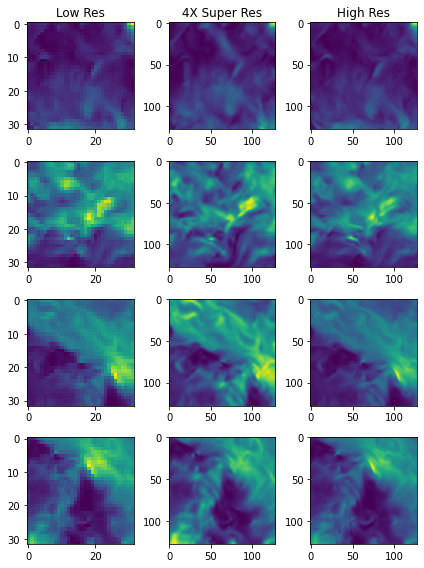

In [13]:

# randomly get 4 pairs of images, use the genG to enlarge the image, show and compare

def enlarge(img):
    img = pd.to_tensor(img)
    img = img.unsqueeze(0)
    img = genG(img)
    img = img.squeeze(0)
    return img

# subplot of 4 * 3 grids
fig, axs = plt.subplots(4, 3, figsize=(6,8))
axs[0,0].set_title("Low Res")
axs[0,1].set_title("4X Super Res")
axs[0,2].set_title("High Res")
for i in range(4):
    small, big = dataset[i]
    super_ = enlarge(small)

    axs[i, 0].imshow(get_energy(small))
    axs[i, 1].imshow(get_energy(super_))
    axs[i, 2].imshow(get_energy(big))

plt.tight_layout()
plt.show()

#### Appendix： 找到数据里面的均值和极值大小

为了将数据标准化到激活函数所在的区域，我们使用了下面的脚本去搜索了(u,v,w)里面的最大值，最后找到大概是2.9 附近，所以如果我们将数据全部除以3，则会得到(-1,1)里面的值，从而可以tanh 激活

In [ ]:
dataset = TurbulenceDataset("data/data169495/isotropic1024coarse_10.h5", 128, 4, 10000, scaler = 1)

seen_max = 0
for i in range(1000):
    _, big = dataset[i]
    biggest_value = pd.max(pd.abs(big)).item()
    if biggest_value > seen_max:
        seen_max = biggest_value
        print(seen_max)